# 1. Parameters

In [1]:
from pathlib import Path
from os import mkdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

simulation_root_dir = Path('simulations')

figures_path = Path('figures')
if not figures_path.exists():
    mkdir(figures_path)
    
min_cov = 10
sub_invariant = 0.3
reference_file = simulation_root_dir / 'reference' / 'reference.fa.gz'

simulation_cases = glob.glob(str(simulation_root_dir / 'cov*')) + glob.glob(str(simulation_root_dir / 'alpha*'))
simulation_cases = [Path(x) for x in simulation_cases]

# 2. Loading data

## 2.1. Counting substitutions between two most distant genomes

In [2]:
haplotypes_reads_paths = [x / 'simulated_data/haplotypes.vcf.gz' for x in simulation_cases]
haplotypes_reads_paths

[PosixPath('simulations/cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-20/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-5/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-40/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-50/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/cov-10/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-5.0-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-0.1-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-10-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-0.05-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-0.5-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-2.0-cov-30/simulated_data/haplotypes.vcf.gz'),
 PosixPath('simulations/alpha-1.0-cov-30/simulated_data/haplotypes.vcf.gz')]

In [3]:
from genomics_data_index.storage.io.mutation.SequenceFile import SequenceFile

reference_name, records = SequenceFile(reference_file).parse_sequence_file()
reference_length = 0
for record in records:
    reference_length = reference_length + len(record)
reference_length

19699

In [4]:
import vcf
from typing import Dict, List, Tuple

sample1 = 'reference'
sample2 = 'SH14-012'

def observed_differences(file: Path, sample1: str, sample2: str) -> Tuple[int, int]:
    reader = vcf.Reader(filename=str(file))
    df = pd.DataFrame([vars(r) for r in reader])
    df['samples_map'] = df['samples'].apply(lambda x: {s.sample: s for s in x})
    df_no_indel = df[~df['samples'].apply(lambda x: x[0].site.is_indel)]
    df_indel = df[df['samples'].apply(lambda x: x[0].site.is_indel)]
    
    number_no_indel = df_no_indel['samples_map'].apply(lambda x: x[sample1].data.GT != x[sample2].data.GT).value_counts()[True]
    all_simulated_mutations = len(df)
    
    return number_no_indel, all_simulated_mutations

def all_observed_diffs(files: List[Path], sample1: str, sample2: str) -> List[int]:
    all_results = [observed_differences(file=x, sample1=sample1, sample2=sample2) for x in files]
    substitution_differences = [x for x,y in all_results]
    all_simulated_mutations = [y for x,y in all_results]
        
    return {
        'Paths': list(map(str, files)),
        'Largest observed substitution difference': substitution_differences,
        'All simulated mutations': all_simulated_mutations,
    }

simulation_mutations = all_observed_diffs(haplotypes_reads_paths, sample1=sample1, sample2=sample2)

In [5]:
obs_subs_df = pd.DataFrame(simulation_mutations)
obs_subs_df['Alpha'] = obs_subs_df['Paths'].str.extract(r'alpha-([^-]+)-').astype(float)
obs_subs_df.loc[obs_subs_df['Paths'].str.contains('/cov-'), 'Alpha'] = 0.2
obs_subs_df['Proportion invariant'] = sub_invariant
obs_subs_df['Reference length bp'] = reference_length
obs_subs_df['Largest substitution divergence'] = obs_subs_df['Largest observed substitution difference'] \
    / obs_subs_df['Reference length bp']
obs_subs_df.loc[:, 'Name of case'] = obs_subs_df['Paths'].str.extract(r'/([^/]+)/simulated_data')
obs_subs_df = obs_subs_df.sort_values('Largest substitution divergence')
obs_subs_df

,Paths,Largest observed substitution difference,All simulated mutations,Alpha,Proportion invariant,Reference length bp,Largest substitution divergence,Name of case
9,simulations/alpha-0.05-cov-30/simulated_data/h...,310,885,0.05,0.3,19699,0.015737,alpha-0.05-cov-30
7,simulations/alpha-0.1-cov-30/simulated_data/ha...,371,1048,0.10,0.3,19699,0.018833,alpha-0.1-cov-30
0,simulations/cov-30/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-30
1,simulations/cov-20/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-20
2,simulations/cov-5/simulated_data/haplotypes.vc...,473,1357,0.20,0.3,19699,0.024011,cov-5
3,simulations/cov-40/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-40
4,simulations/cov-50/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-50
5,simulations/cov-10/simulated_data/haplotypes.v...,473,1357,0.20,0.3,19699,0.024011,cov-10
10,simulations/alpha-0.5-cov-30/simulated_data/ha...,827,2221,0.50,0.3,19699,0.041982,alpha-0.5-cov-30
12,simulations/alpha-1.0-cov-30/simulated_data/ha...,1333,3410,1.00,0.3,19699,0.067668,alpha-1.0-cov-30


In [6]:
obs_subs_df.loc[:, 'Type of case'] = 'reads'
obs_subs_assemblies = obs_subs_df.copy()
obs_subs_assemblies.loc[:, 'Type of case'] = 'assemblies'
obs_subs_df = pd.concat([obs_subs_df, obs_subs_assemblies])
obs_subs_df.loc[:, 'Name with type'] = obs_subs_df['Name of case'] + ' ' + obs_subs_df['Type of case']
obs_subs_df = obs_subs_df[['Name of case', 'Name with type', 'Largest observed substitution difference',
                           'Largest substitution divergence',
                          'Reference length bp']]
obs_subs_df

,Name of case,Name with type,Largest observed substitution difference,Largest substitution divergence,Reference length bp
9,alpha-0.05-cov-30,alpha-0.05-cov-30 reads,310,0.015737,19699
7,alpha-0.1-cov-30,alpha-0.1-cov-30 reads,371,0.018833,19699
0,cov-30,cov-30 reads,473,0.024011,19699
1,cov-20,cov-20 reads,473,0.024011,19699
2,cov-5,cov-5 reads,473,0.024011,19699
3,cov-40,cov-40 reads,473,0.024011,19699
4,cov-50,cov-50 reads,473,0.024011,19699
5,cov-10,cov-10 reads,473,0.024011,19699
10,alpha-0.5-cov-30,alpha-0.5-cov-30 reads,827,0.041982,19699
12,alpha-1.0-cov-30,alpha-1.0-cov-30 reads,1333,0.067668,19699


## 2.2. Loading index information

In [7]:
from typing import List

index_info_reads_paths = [x / 'reads-index-info.tsv' for x in simulation_cases]
index_info_reads_paths = [x for x in index_info_reads_paths if x.exists()]

index_info_assemblies_paths = [x / 'assemblies-index-info.tsv' for x in simulation_cases]
index_info_assemblies_paths = [x for x in index_info_assemblies_paths if x.exists()]

def read_all_df(df_paths: List[Path], name_col: str = 'Name', override_type: bool = True) -> pd.DataFrame:
    dfs = []
    for df_path in df_paths:
        dfs.append(pd.read_csv(df_path, sep='\t'))
    dfs_concat = pd.concat(dfs).reset_index(drop=True)
        
    if override_type:
        dfs_concat['Type'] = dfs_concat[name_col].str.extract(r'^\S+ (\w+)')
    dfs_concat['Coverage'] = dfs_concat[name_col].str.extract(r'cov-(\d+)').astype(int)
    dfs_concat['Alpha'] = dfs_concat[name_col].str.extract(r'alpha-([^-]+)-').astype(float)
    dfs_concat.loc[dfs_concat[name_col].str.match(r'^cov'), 'Alpha'] = 0.2
        
    return dfs_concat

index_info_df = read_all_df(index_info_reads_paths + index_info_assemblies_paths)
index_info_df.head(5)

,Name,Reference name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),...,Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Type,Coverage,Alpha
0,cov-30 reads,reference,1,59,3412,1313,32,19699,120.32,3.048968e+09,...,292241408.0,2195456.0,97.17,273711104.0,234151936.0,226.06,5.960876e+09,reads,30,0.2
1,cov-30 reads,reference,2,59,3412,1313,32,19699,116.90,2.547585e+09,...,292130816.0,2195456.0,90.43,274096128.0,234192896.0,215.89,5.951451e+09,reads,30,0.2
2,cov-30 reads,reference,3,59,3412,1313,32,19699,121.98,3.051438e+09,...,292102144.0,2191360.0,95.51,274333696.0,234897408.0,225.61,5.941256e+09,reads,30,0.2
3,cov-20 reads,reference,1,59,9648,1290,32,19699,116.06,3.033461e+09,...,317030400.0,2555904.0,111.45,295628800.0,234397696.0,237.32,5.962846e+09,reads,20,0.2
4,cov-20 reads,reference,2,59,9648,1290,32,19699,119.76,3.146228e+09,...,317972480.0,2551808.0,107.52,296480768.0,234913792.0,237.10,5.965418e+09,reads,20,0.2


# 3. Index

In [8]:
stages_palette = ['#1b9e77', '#7570b3', '#d95f02', '#000000']
stages_markers = ['o', 's', '^', 'X']
stages_palette_nototal = ['#1b9e77', '#7570b3', '#d95f02']
stages_markers_nototal = ['o', 's', '^']
stages_palette_notree = ['#1b9e77', '#7570b3', '#000000']
stages_markers_notree = ['o', 's', 'X']

## 3.1. Runtime plots

In [9]:
from typing import Callable

def melt_runtimes(df: pd.DataFrame, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    value_vars = ['Analysis runtime', 'Index runtime', 'Tree runtime', 'Total runtime']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df = df.rename({'variable': 'Stage', 'value': 'Time (seconds)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' runtime', '', regex=False)
    df['Time (minutes)'] = df['Time (seconds)'] / 60
    df['Time (hours)'] = df['Time (seconds)'] / 3600
    return df

index_info_runtime_df = melt_runtimes(index_info_df, id_vars=['Type', 'Coverage', 'Alpha'])
index_info_runtime_df

,Type,Coverage,Alpha,Stage,Time (seconds),Time (minutes),Time (hours)
0,reads,30,0.2,Analysis,120.32,2.005333,0.033422
1,reads,30,0.2,Analysis,116.90,1.948333,0.032472
2,reads,30,0.2,Analysis,121.98,2.033000,0.033883
3,reads,20,0.2,Analysis,116.06,1.934333,0.032239
4,reads,20,0.2,Analysis,119.76,1.996000,0.033267
...,...,...,...,...,...,...,...
307,assemblies,30,2.0,Total,152.98,2.549667,0.042494
308,assemblies,30,2.0,Total,155.93,2.598833,0.043314
309,assemblies,30,1.0,Total,138.15,2.302500,0.038375
310,assemblies,30,1.0,Total,136.86,2.281000,0.038017


### 3.1.1. Runtime vs. coverage

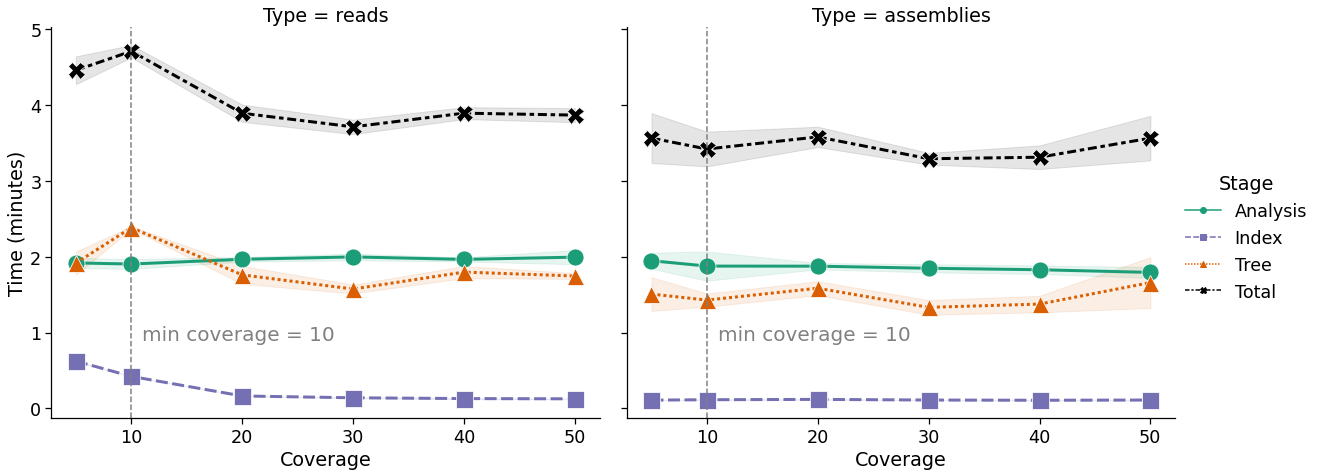

In [10]:
coverage_runtime_df = index_info_runtime_df[index_info_runtime_df['Alpha'] == 0.2]

with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Coverage', y='Time (minutes)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=coverage_runtime_df, col="Type", markers=stages_markers, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette,
                    facet_kws={'sharey': True, 'sharex': True})
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.8
        ax.text(min_cov + 1, ypos, f'min coverage = {min_cov}', fontdict={'size': 20, 'color': 'gray'})
        
    plt.savefig('figures/index-runtime-coverage.pdf')

### 3.1.2. Runtime vs. alpha (transition rate)

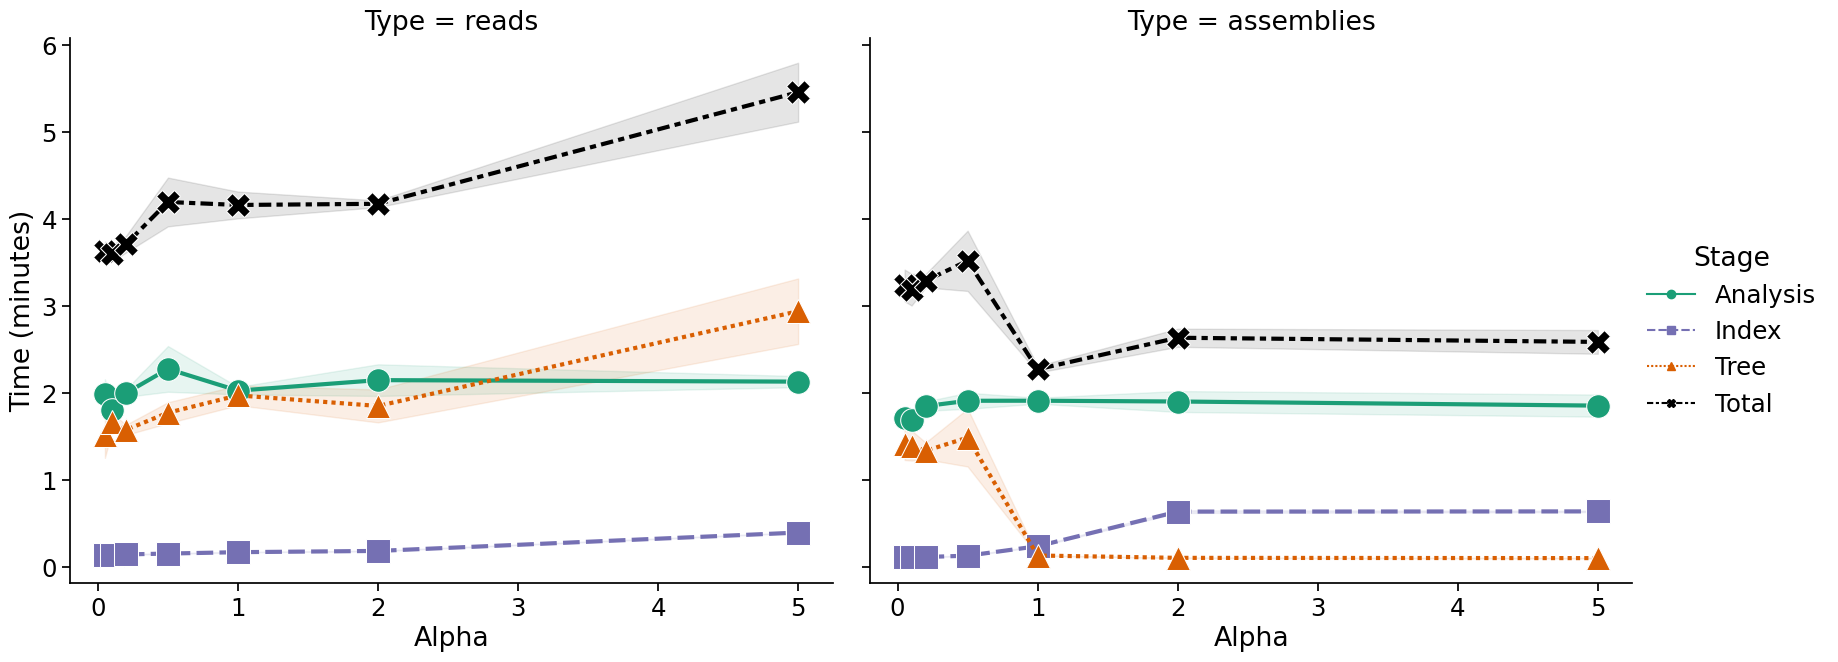

In [11]:
alpha_runtime_df = index_info_runtime_df[index_info_runtime_df['Coverage'] == 30]

# Remove this case since it failed
alpha_runtime_df = alpha_runtime_df[alpha_runtime_df['Alpha'] != 10]

with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Alpha', y='Time (minutes)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=alpha_runtime_df, col="Type", markers=stages_markers, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette,
                    facet_kws={'sharey': True, 'sharex': True})
    plt.savefig('figures/index-runtime-alpha.pdf')

## 3.2. Analysis memory plots

In [12]:
def melt_memory(df: pd.DataFrame, id_vars: str) -> pd.DataFrame:
    value_vars = ['Analysis memory (max)', 'Index memory (max)', 'Tree memory (max)']

    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Peak Memory (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' memory (max)', '', regex=False)
    return df

index_info_memory_df = melt_memory(index_info_df, id_vars=['Type', 'Coverage', 'Alpha'])
index_info_memory_df

,Type,Coverage,Alpha,Stage,Peak Memory (GB)
0,reads,30,0.2,Analysis,2.839573
1,reads,30,0.2,Analysis,2.372623
2,reads,30,0.2,Analysis,2.841873
3,reads,20,0.2,Analysis,2.825130
4,reads,20,0.2,Analysis,2.930153
...,...,...,...,...,...
229,assemblies,30,2.0,Tree,0.227852
230,assemblies,30,2.0,Tree,0.227509
231,assemblies,30,1.0,Tree,0.228535
232,assemblies,30,1.0,Tree,0.228851


### 3.2.1. Peak memory vs coverage

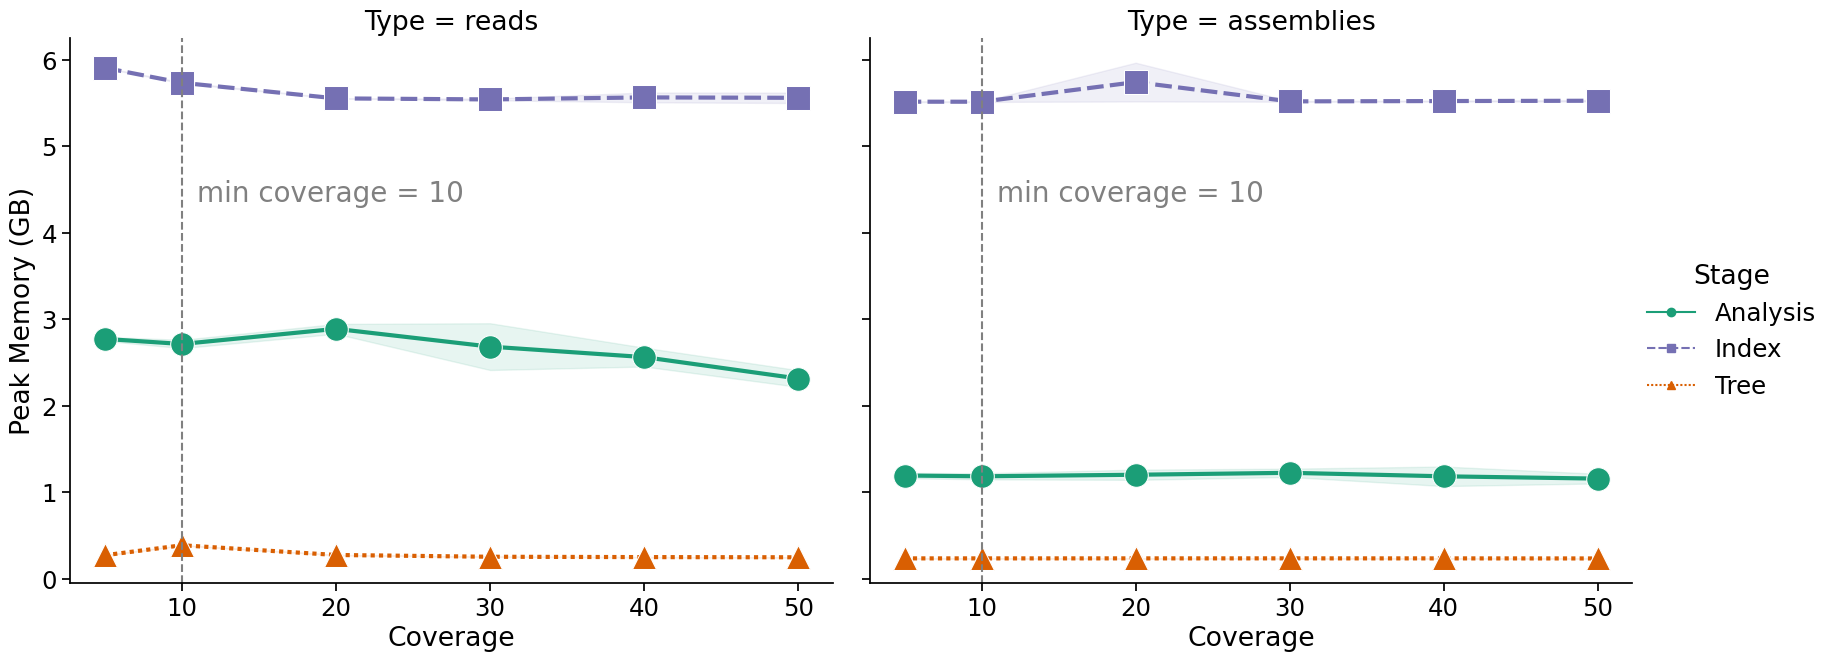

In [13]:
coverage_memory_df = index_info_memory_df[index_info_memory_df['Alpha'] == 0.2]

with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Coverage', y='Peak Memory (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=coverage_memory_df, col="Type", markers=stages_markers_nototal, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette_nototal,
                    facet_kws={'sharey': True, 'sharex': True})
    
    for ax in g.axes.flat:
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.3
        ax.text(min_cov + 1, ypos, f'min coverage = {min_cov}', fontdict={'size': 20, 'color': 'gray'})
        
    plt.savefig('figures/index-memory-coverage.pdf')

### 3.2.2. Peak memory vs alpha (transition rate)

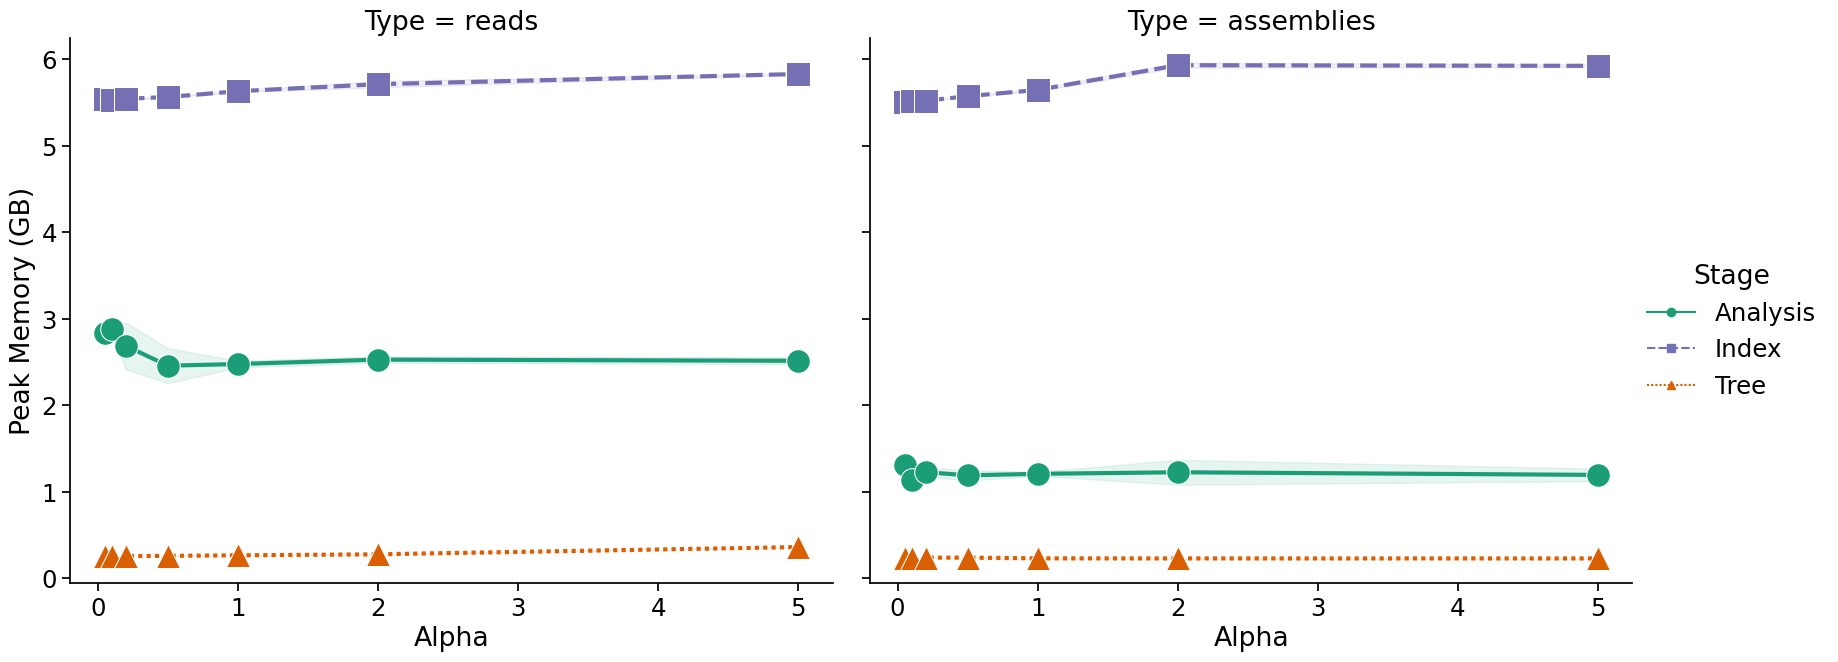

In [14]:
alpha_memory_df = index_info_memory_df[index_info_memory_df['Coverage'] == 30]

# Remove this case since it failed
alpha_memory_df = alpha_memory_df[alpha_memory_df['Alpha'] != 10]

with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Alpha', y='Peak Memory (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=alpha_memory_df, col="Type", markers=stages_markers_nototal, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette_nototal,
                    facet_kws={'sharey': True, 'sharex': True})
    plt.savefig('figures/index-memory-alpha.pdf')

## 3.3. Disk usage plots

In [15]:
def melt_disk_usage(df: pd.DataFrame, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    df['Total size'] = df['Analysis disk uage'] + df['Index size']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=['Analysis disk uage', 'Index size', 'Total size'])
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Disk (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' disk uage', '', regex=False)
    df['Stage'] = df['Stage'].str.replace(' size', '', regex=False)
    return df

index_info_disk_df = melt_disk_usage(index_info_df, id_vars=['Type', 'Coverage', 'Alpha'])
index_info_disk_df

,Type,Coverage,Alpha,Stage,Disk (GB)
0,reads,30,0.2,Analysis,2.754875
1,reads,30,0.2,Analysis,2.754890
2,reads,30,0.2,Analysis,2.754887
3,reads,20,0.2,Analysis,2.745697
4,reads,20,0.2,Analysis,2.745705
...,...,...,...,...,...
229,assemblies,30,2.0,Total,2.051224
230,assemblies,30,2.0,Total,2.051197
231,assemblies,30,1.0,Total,2.055428
232,assemblies,30,1.0,Total,2.055405


### 3.3.1. Disk usage vs. coverage

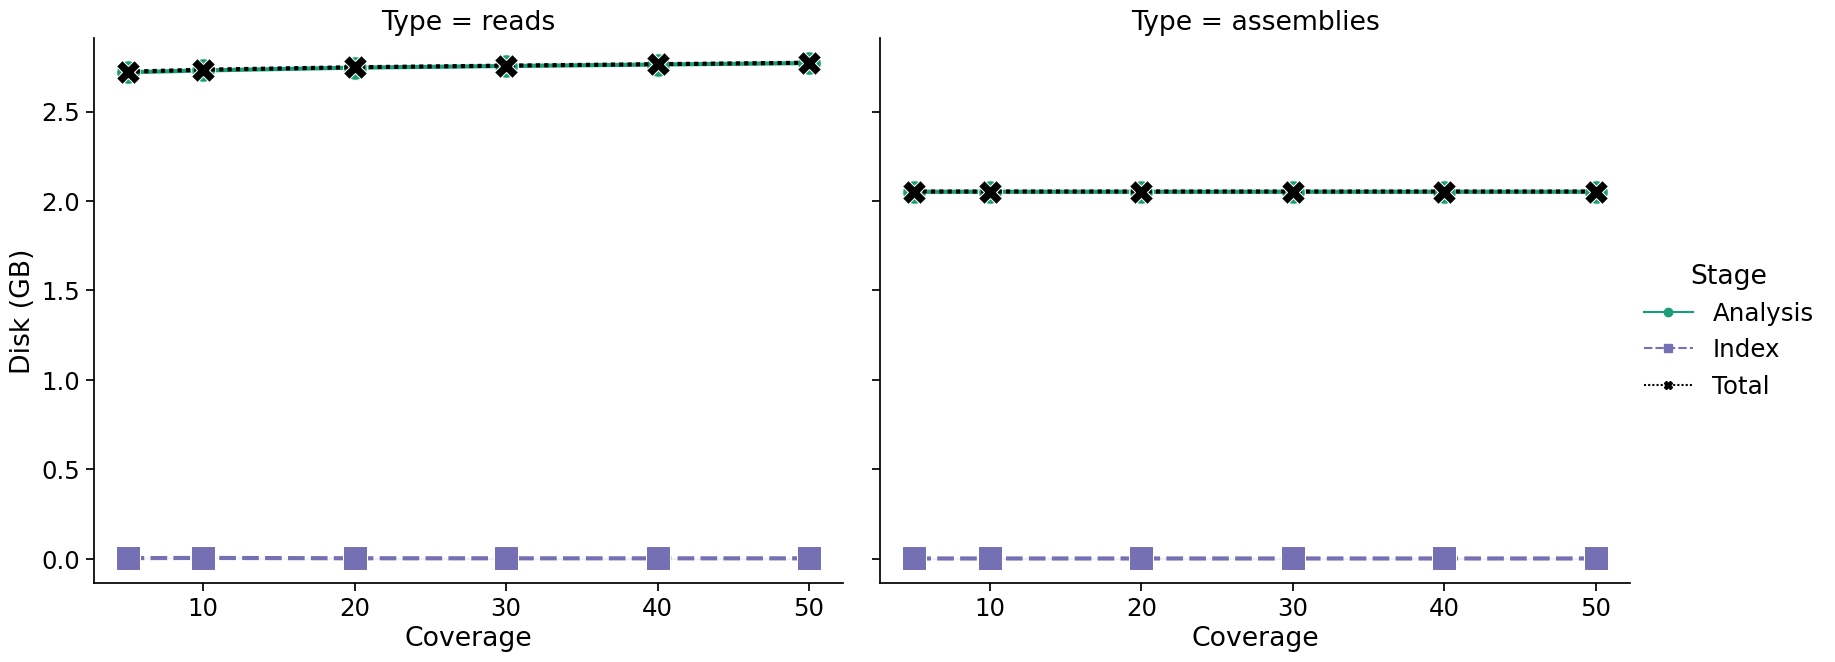

In [16]:
coverage_disk_df = index_info_disk_df[index_info_disk_df['Alpha'] == 0.2]

with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Coverage', y='Disk (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=coverage_disk_df, col="Type", markers=stages_markers_notree, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette_notree,
                    facet_kws={'sharey': True, 'sharex': True})
    plt.savefig('figures/index-disk-coverage.pdf')

### 3.3.2. Disk usage vs. alpha (transition rate)

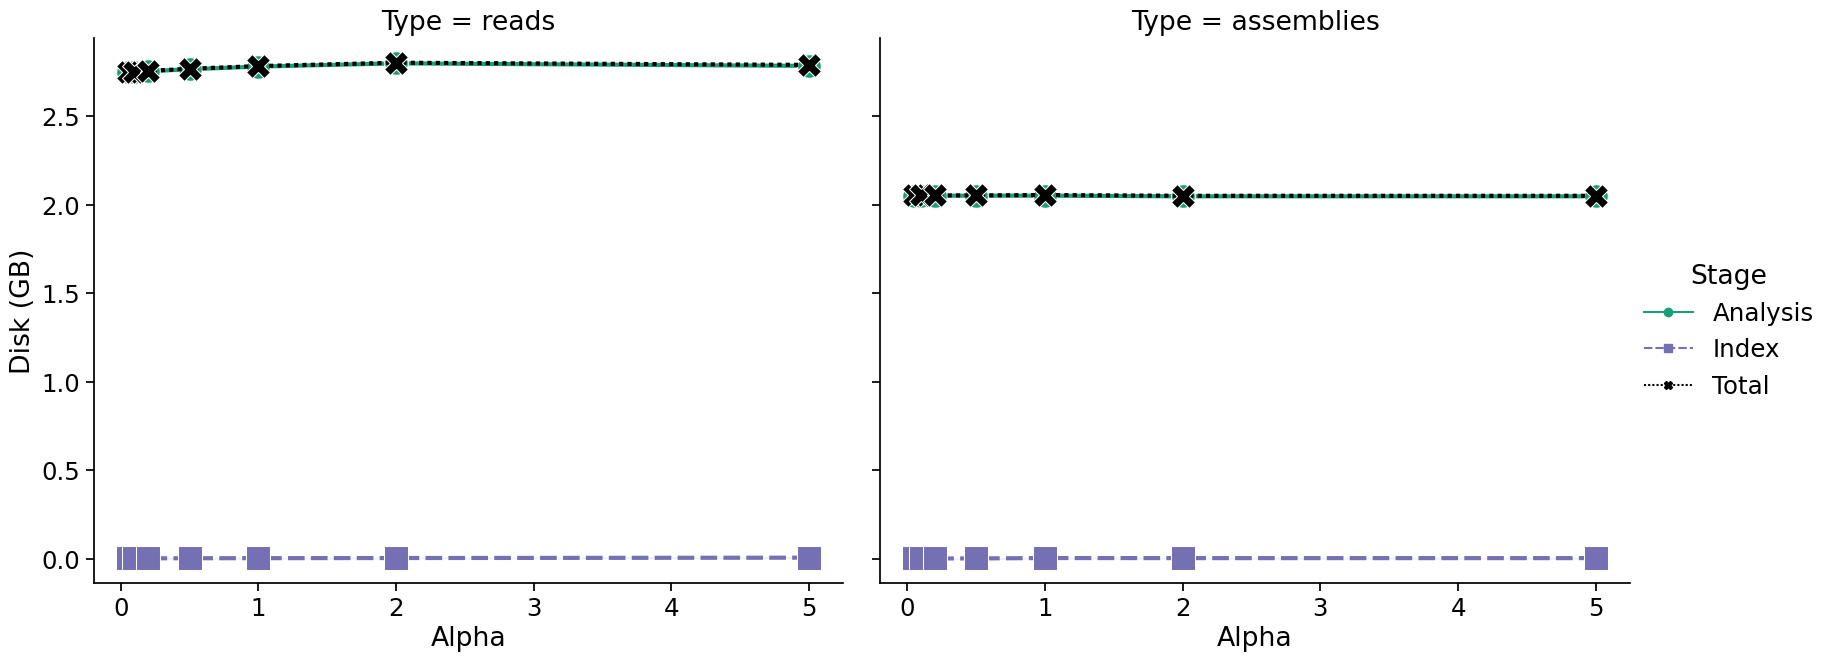

In [17]:
alpha_disk_df = index_info_disk_df[index_info_disk_df['Coverage'] == 30]

# Remove this case since it failed
alpha_disk_df = alpha_disk_df[alpha_disk_df['Alpha'] != 10]

with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Alpha', y='Disk (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=alpha_disk_df, col="Type", markers=stages_markers_notree, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette_notree,
                    facet_kws={'sharey': True, 'sharex': True})
    plt.savefig('figures/index-disk-alpha.pdf')

# 4. Querying

## 4.1. Querying API

In [18]:
query_reads_paths = [x / 'query-reads-api.tsv' for x in simulation_cases]
query_reads_paths = [x for x in query_reads_paths if x.exists()]
query_assemblies_paths = [x / 'query-assemblies-api.tsv' for x in simulation_cases]
query_assemblies_paths = [x for x in query_assemblies_paths if x.exists()]

query_reads_df = read_all_df(query_reads_paths)
query_reads_df['Type'] = 'reads'
query_assemblies_df = read_all_df(query_assemblies_paths)
query_assemblies_df['Type'] = 'assemblies'

query_df = pd.concat([query_reads_df, query_assemblies_df]).reset_index()

query_df['Time'] = query_df['Time'].apply(lambda x: x * 1000)
query_df = query_df.rename({'Time': 'Time (ms)'}, axis='columns')

# Get rid of some query measures to make plots easier to read
query_df = query_df[query_df['Kind'] != 'q.isin (mrca)']

# Divide up kinds of queries into classes
query_df['Time scale'] = 'Short'
query_df.loc[query_df['Kind'].isin(
    ['q.features_comparison', 'q.features_summary']), 'Time scale'] = 'Long'

query_df = query_df.sort_values('Time scale', ascending=False)

query_df.head(5)

,index,Name,Kind,Number samples,Number features (no unknown),Number features (all),Number executions,Iteration,Time (ms),Type,Coverage,Alpha,Time scale
0,0,cov-30 (reads),db.samples_query,59,1313,3412,200,1,1.692138,reads,30,0.2,Short
1439,119,cov-20 (assemblies),db.samples_query,59,1350,1426,200,10,1.652464,assemblies,20,0.2,Short
1471,151,cov-20 (assemblies),q.hasa,59,1350,1426,200,2,1.033817,assemblies,20,0.2,Short
1470,150,cov-20 (assemblies),q.hasa,59,1350,1426,200,1,1.030711,assemblies,20,0.2,Short
1449,129,cov-20 (assemblies),q.join,59,1350,1426,200,10,1.621336,assemblies,20,0.2,Short


### 4.1.1. Compare runtime for single coverage

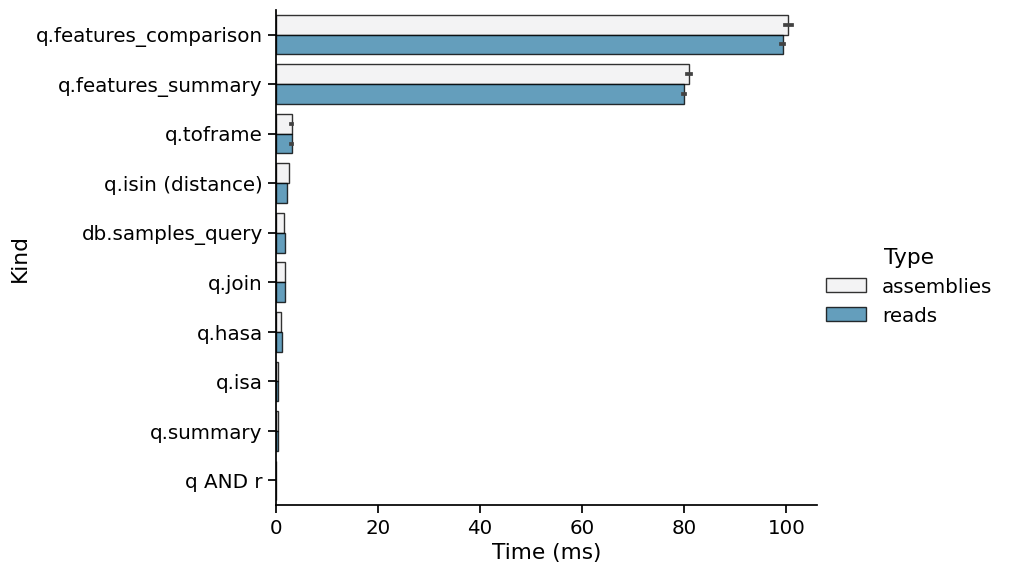

In [19]:
query_cov_single = query_df[query_df['Coverage'] == 50]
query_cov_single = query_cov_single.sort_values('Time (ms)', ascending=False)

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=query_cov_single, kind="bar",
        y="Kind", x="Time (ms)", hue="Type",
        ci="sd", height=6, aspect=1.5, alpha=0.8, color="#2b8cbe", edgecolor="black"
    )
    plt.savefig('figures/query-api-coverage-cov50.pdf')

### 4.1.2. Compare runtime vs. all coverages

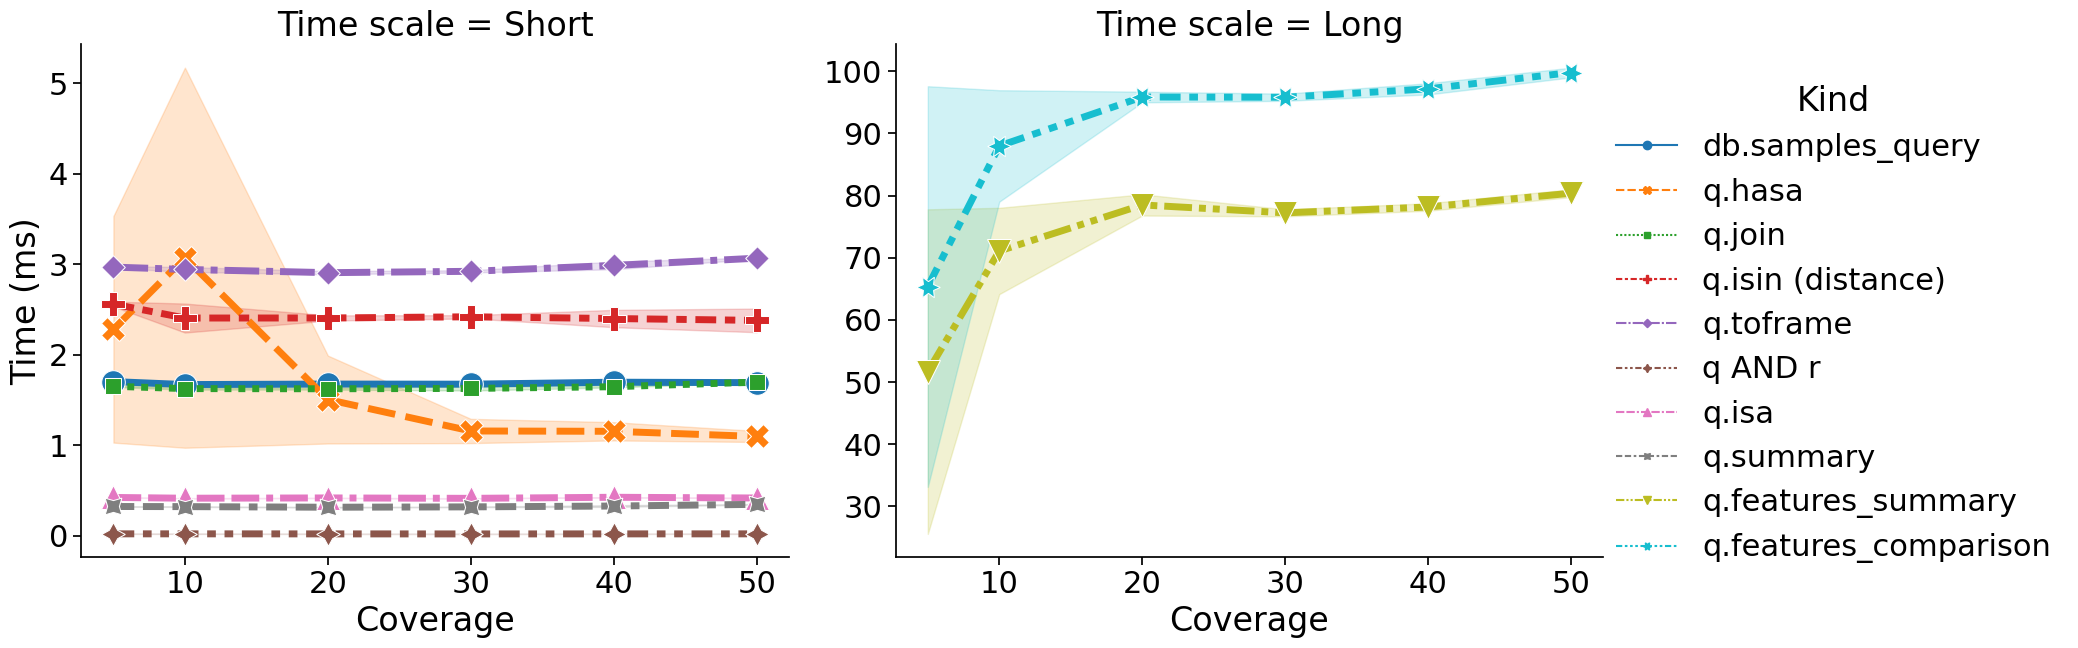

In [20]:
query_coverage_df = query_df[query_df['Alpha'] == 0.2]

with sns.plotting_context("notebook", font_scale=2):
    g = sns.relplot(x='Coverage', y='Time (ms)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_coverage_df, markers=True, estimator='mean', col='Time scale',
                    height=7, aspect=1.2, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})
    plt.savefig('figures/query-api-coverage.pdf')

### 4.1.3. Runtime vs. alpha

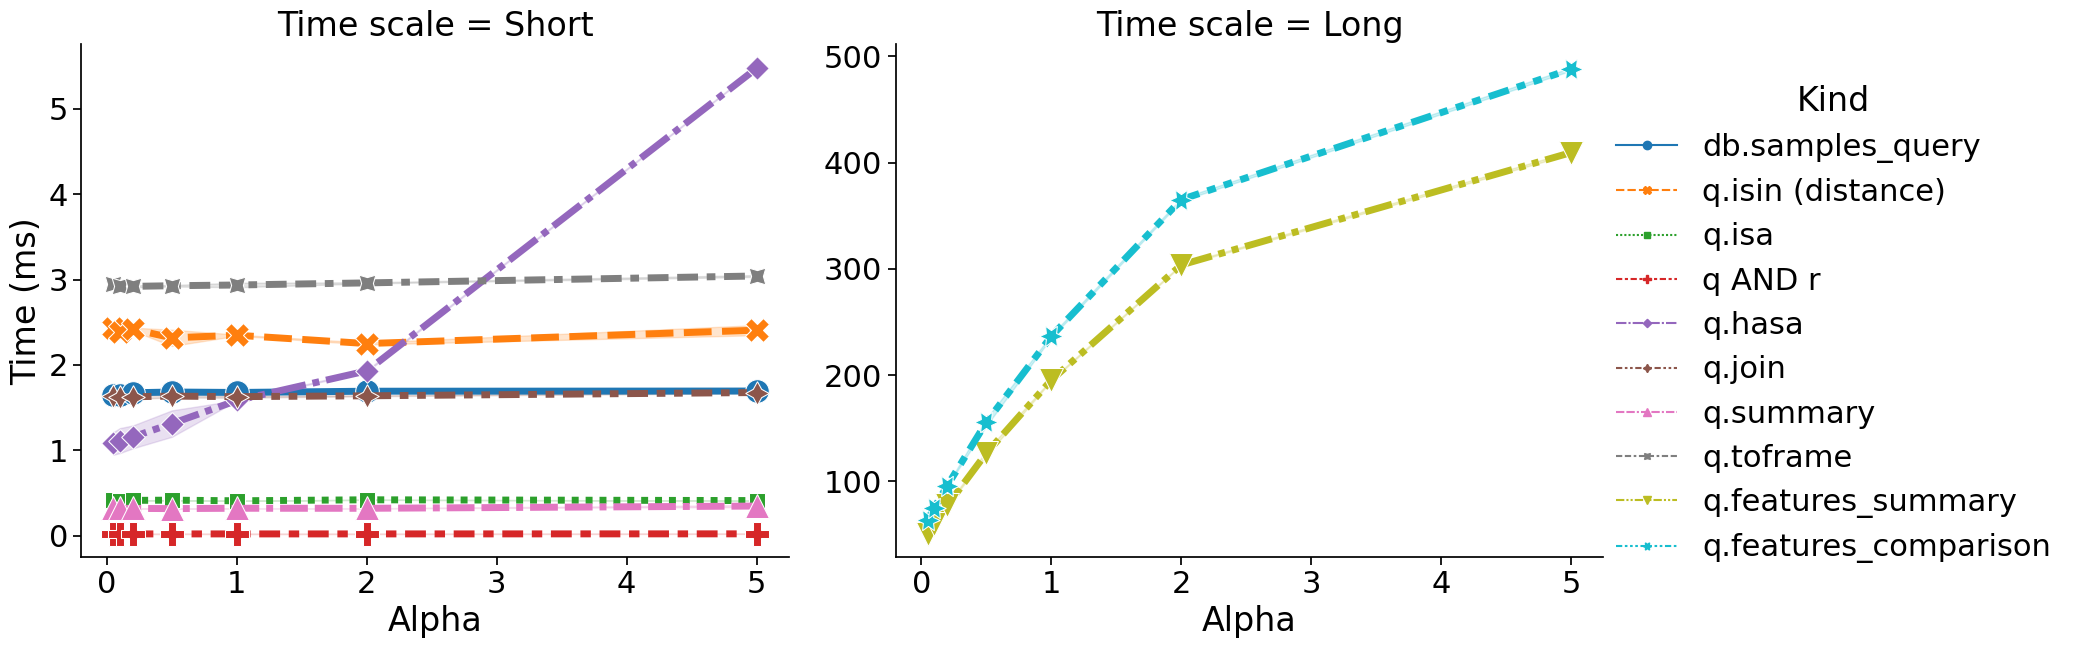

In [21]:
query_alpha_df = query_df[query_df['Coverage'] == 30]

with sns.plotting_context("notebook", font_scale=2):
    g = sns.relplot(x='Alpha', y='Time (ms)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_alpha_df, markers=True, estimator='mean', col='Time scale',
                    height=7, aspect=1.2, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})
    plt.savefig('figures/query-api-alpha.pdf')

# 5. Features comparison

In [22]:
features_paths = [x / 'variants-comparison.tsv' for x in simulation_cases]
features_paths = [x for x in features_paths if x.exists()]

features_df = read_all_df(features_paths)
    
features_df = features_df.merge(obs_subs_df, left_on='Name',
                              right_on='Name with type',
                              how='inner')

features_count_df = pd.melt(features_df, id_vars=['Type', 'Coverage', 'Alpha',
                                                  'Largest substitution divergence'],
        value_vars=['True Positives', 'False Positives', 'False Negatives'])
features_count_df = features_count_df.rename({'value': 'Count'}, axis='columns')

features_score_df = pd.melt(features_df, id_vars=['Type', 'Coverage', 'Alpha',
                                                 'Largest substitution divergence'],
                            value_vars=['Sensitivity', 'Precision', 'F1 Score'])
features_score_df = features_score_df.rename({'value': 'Score'}, axis='columns')
features_count_df

,Type,Coverage,Alpha,Largest substitution divergence,variable,Count
0,reads,30,0.2,0.024011,True Positives,14851
1,assemblies,30,0.2,0.024011,True Positives,16762
2,reads,20,0.2,0.024011,True Positives,14401
3,assemblies,20,0.2,0.024011,True Positives,16762
4,reads,5,0.2,0.024011,True Positives,415
...,...,...,...,...,...,...
67,assemblies,30,0.5,0.041982,False Negatives,238
68,reads,30,2.0,0.104015,False Negatives,40862
69,assemblies,30,2.0,0.104015,False Negatives,83521
70,reads,30,1.0,0.067668,False Negatives,17629


In [23]:
features_score_df

,Type,Coverage,Alpha,Largest substitution divergence,variable,Score
0,reads,30,0.2,0.024011,Sensitivity,0.877097
1,assemblies,30,0.2,0.024011,Sensitivity,0.989960
2,reads,20,0.2,0.024011,Sensitivity,0.850520
3,assemblies,20,0.2,0.024011,Sensitivity,0.989960
4,reads,5,0.2,0.024011,Sensitivity,0.024510
...,...,...,...,...,...,...
67,assemblies,30,0.5,0.041982,F1 Score,0.996178
68,reads,30,2.0,0.104015,F1 Score,0.608145
69,assemblies,30,2.0,0.104015,F1 Score,0.032325
70,reads,30,1.0,0.067668,F1 Score,0.736225


In [24]:
markers_data_type = ['o', 's']

In [25]:
plot_transition_scale = features_count_df[(features_count_df['Coverage'] == 30) & 
                  (features_count_df['Type'] == 'reads') & 
                  (features_count_df['variable'] == 'True Positives')]
plot_transition_scale = plot_transition_scale.rename({'Alpha': 'Transition rate'}, axis='columns')
plot_transition_scale = plot_transition_scale.sort_values('Transition rate')
plot_transition_scale

,Type,Coverage,Transition rate,Largest substitution divergence,variable,Count
16,reads,30,0.05,0.015737,True Positives,9859
14,reads,30,0.10,0.018833,True Positives,11905
0,reads,30,0.20,0.024011,True Positives,14851
18,reads,30,0.50,0.041982,True Positives,24199
22,reads,30,1.00,0.067668,True Positives,34621
20,reads,30,2.00,0.104015,True Positives,44054
12,reads,30,5.00,0.176709,True Positives,31570


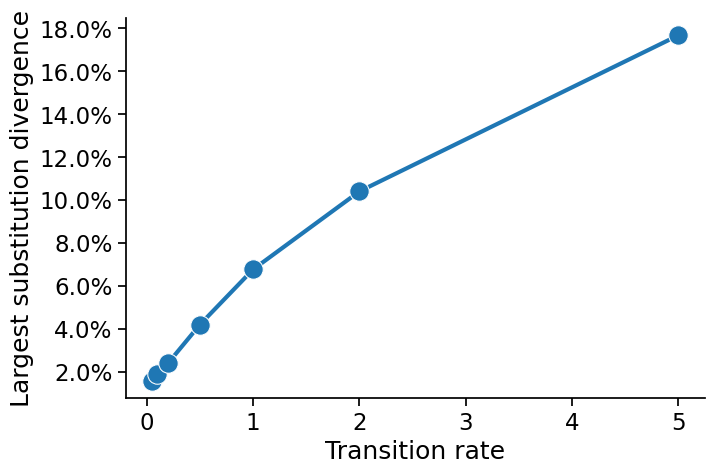

In [26]:
import matplotlib.ticker as mtick

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Transition rate', y='Largest substitution divergence', style="Type", hue="Type", kind="line",
                    data=plot_transition_scale, estimator='mean',
                    height=5, aspect=1.5, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=['o'],
                    facet_kws={'sharey': False, 'sharex': True})
    g._legend.remove()
    
    for idx, ax in enumerate(g.axes.flat):
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        
    plt.savefig('figures/largest-substitution-divergence.pdf')

## 5.1. Comparison of true negative/positive counts

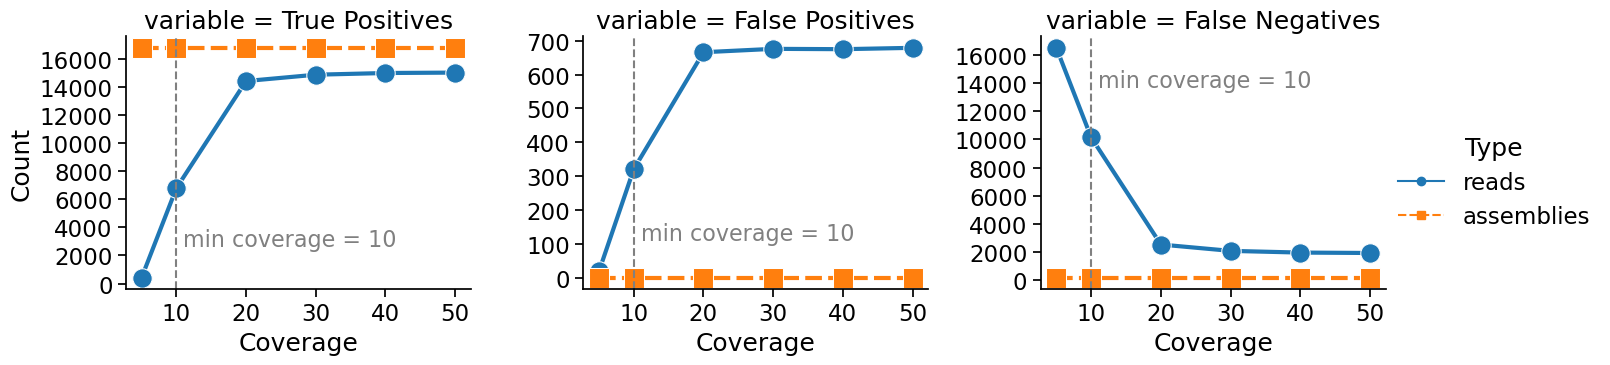

In [27]:
features_count_coverage_df = features_count_df[features_count_df['Alpha'] == 0.2]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Coverage', y='Count', hue="Type", style="Type", ci="sd", kind="line",
                    data=features_count_coverage_df, col="variable", estimator='mean',
                    height=4, aspect=1.2, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=markers_data_type,
                    facet_kws={'sharey': False, 'sharex': True})
    
    for idx, ax in enumerate(g.axes.flat):
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        if idx == 2:
            ypos = ylim[1] - ylen * 0.2
        else:
            ypos = ylen * 0.15
        ax.text(min_cov + 1, ypos, f'min coverage = {min_cov}', fontdict={'size': 16, 'color': 'gray'})
        
    plt.savefig('figures/features-coverage-counts.pdf')

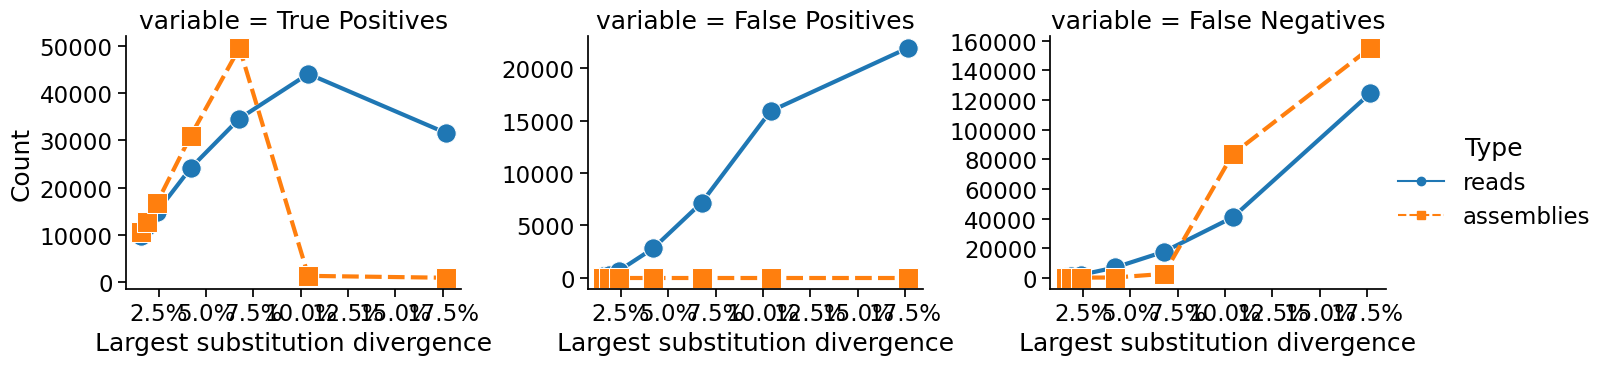

In [28]:
features_count_alpha_df = features_count_df[features_count_df['Coverage'] == 30]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Largest substitution divergence', y='Count', hue="Type", style="Type", ci="sd", kind="line",
                    data=features_count_alpha_df, col="variable", estimator='mean',
                    height=4, aspect=1.2, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=markers_data_type,
                    facet_kws={'sharey': False, 'sharex': True})
    
    for idx, ax in enumerate(g.axes.flat):
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    plt.savefig('figures/features-alpha-counts.pdf')

## 5.2. Comparison of scores

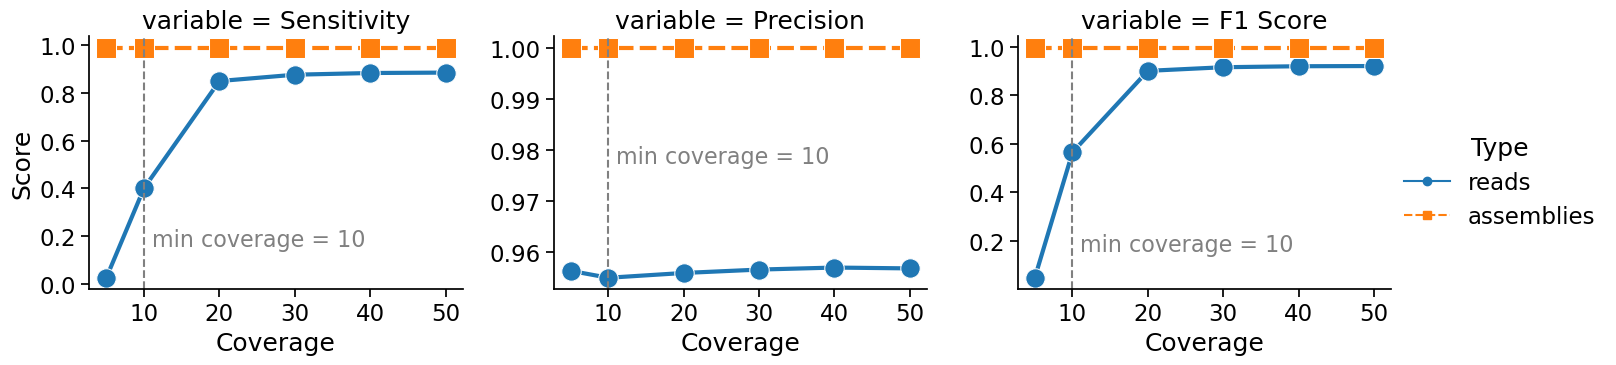

In [29]:
features_score_coverage_df = features_score_df[features_score_df['Alpha'] == 0.2]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Coverage', y='Score', hue="Type", style="Type", ci="sd", kind="line",
                    data=features_score_coverage_df, col="variable", estimator='mean',
                    height=4, aspect=1.2, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=markers_data_type,
                    facet_kws={'sharey': False, 'sharex': True})
    
    for idx, ax in enumerate(g.axes.flat):
        ax.axvline(min_cov, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        if idx == 1:
            ypos = ylim[1] - ylen * 0.5
        else:
            ypos = ylen * 0.15
        ax.text(min_cov + 1, ypos, f'min coverage = {min_cov}', fontdict={'size': 16, 'color': 'gray'})
        
    plt.savefig('figures/features-coverage-scores.pdf')

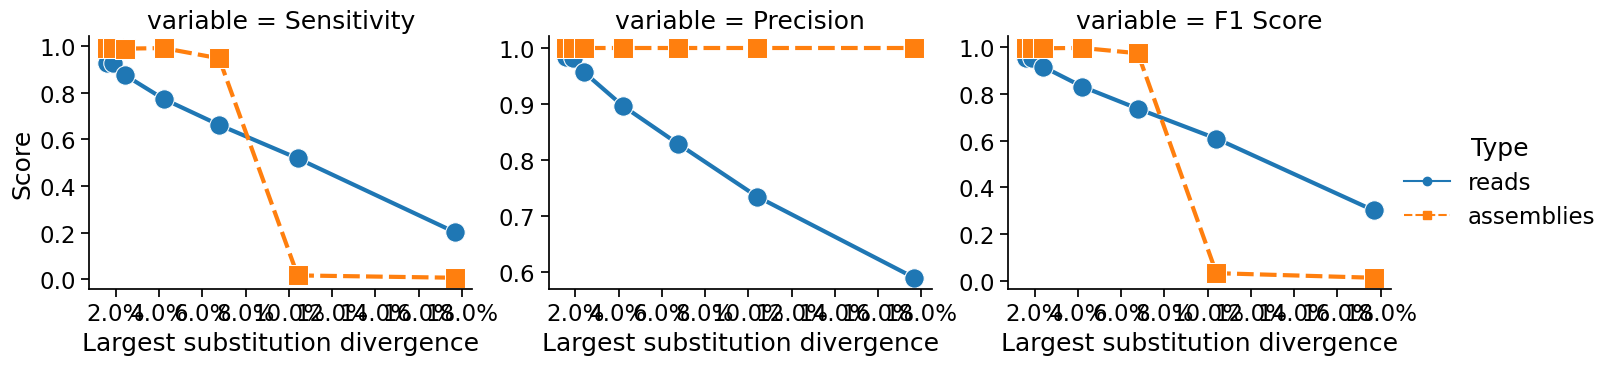

In [30]:
features_score_alpha_df = features_score_df[features_score_df['Coverage'] == 30]

with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Largest substitution divergence', y='Score', hue="Type", style="Type", ci="sd", kind="line",
                    data=features_score_alpha_df, col="variable", estimator='mean',
                    height=4, aspect=1.2, linewidth=3, markersize=14, err_kws={"alpha": 0.1},
                    markers=markers_data_type,
                    facet_kws={'sharey': False, 'sharex': True})
    
    for idx, ax in enumerate(g.axes.flat):
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    plt.savefig('figures/features-alpha-scores.pdf')

## 5.3. Counts

### 5.3.1. TP

In [31]:
features_count_df[features_count_df['variable'] == 'True Positives'].sort_values(['Type', 'Count'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Count
13,assemblies,30,5.00,0.176709,True Positives,996
21,assemblies,30,2.00,0.104015,True Positives,1395
17,assemblies,30,0.05,0.015737,True Positives,10553
15,assemblies,30,0.10,0.018833,True Positives,12757
1,assemblies,30,0.20,0.024011,True Positives,16762
3,assemblies,20,0.20,0.024011,True Positives,16762
5,assemblies,5,0.20,0.024011,True Positives,16762
7,assemblies,40,0.20,0.024011,True Positives,16762
9,assemblies,50,0.20,0.024011,True Positives,16762
11,assemblies,10,0.20,0.024011,True Positives,16762


### 5.3.2. FP

In [32]:
features_count_df[features_count_df['variable'] == 'False Positives'].sort_values(['Type', 'Count'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Count
25,assemblies,30,0.20,0.024011,False Positives,0
27,assemblies,20,0.20,0.024011,False Positives,0
29,assemblies,5,0.20,0.024011,False Positives,0
31,assemblies,40,0.20,0.024011,False Positives,0
33,assemblies,50,0.20,0.024011,False Positives,0
35,assemblies,10,0.20,0.024011,False Positives,0
37,assemblies,30,5.00,0.176709,False Positives,0
39,assemblies,30,0.10,0.018833,False Positives,0
41,assemblies,30,0.05,0.015737,False Positives,0
43,assemblies,30,0.50,0.041982,False Positives,0


### 5.3.3. FN

In [33]:
features_count_df[features_count_df['variable'] == 'False Negatives'].sort_values(['Type', 'Count'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Count
65,assemblies,30,0.05,0.015737,False Negatives,76
63,assemblies,30,0.10,0.018833,False Negatives,84
49,assemblies,30,0.20,0.024011,False Negatives,170
51,assemblies,20,0.20,0.024011,False Negatives,170
53,assemblies,5,0.20,0.024011,False Negatives,170
55,assemblies,40,0.20,0.024011,False Negatives,170
57,assemblies,50,0.20,0.024011,False Negatives,170
59,assemblies,10,0.20,0.024011,False Negatives,170
67,assemblies,30,0.50,0.041982,False Negatives,238
71,assemblies,30,1.00,0.067668,False Negatives,2698


### 5.3.4. Sensitivity

In [34]:
features_score_df[features_score_df['variable'] == 'Sensitivity'].sort_values(['Type', 'Score'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Score
13,assemblies,30,5.00,0.176709,Sensitivity,0.006375
21,assemblies,30,2.00,0.104015,Sensitivity,0.016428
23,assemblies,30,1.00,0.067668,Sensitivity,0.948364
1,assemblies,30,0.20,0.024011,Sensitivity,0.989960
3,assemblies,20,0.20,0.024011,Sensitivity,0.989960
5,assemblies,5,0.20,0.024011,Sensitivity,0.989960
7,assemblies,40,0.20,0.024011,Sensitivity,0.989960
9,assemblies,50,0.20,0.024011,Sensitivity,0.989960
11,assemblies,10,0.20,0.024011,Sensitivity,0.989960
19,assemblies,30,0.50,0.041982,Sensitivity,0.992386


### 5.3.5. Precision

In [35]:
features_score_df[features_score_df['variable'] == 'Precision'].sort_values(['Type', 'Score'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Score
25,assemblies,30,0.20,0.024011,Precision,1.000000
27,assemblies,20,0.20,0.024011,Precision,1.000000
29,assemblies,5,0.20,0.024011,Precision,1.000000
31,assemblies,40,0.20,0.024011,Precision,1.000000
33,assemblies,50,0.20,0.024011,Precision,1.000000
35,assemblies,10,0.20,0.024011,Precision,1.000000
37,assemblies,30,5.00,0.176709,Precision,1.000000
39,assemblies,30,0.10,0.018833,Precision,1.000000
41,assemblies,30,0.05,0.015737,Precision,1.000000
43,assemblies,30,0.50,0.041982,Precision,1.000000


### 5.3.6. F1 Score

In [36]:
features_score_df[features_score_df['variable'] == 'F1 Score'].sort_values(['Type', 'Score'])

,Type,Coverage,Alpha,Largest substitution divergence,variable,Score
61,assemblies,30,5.00,0.176709,F1 Score,0.012670
69,assemblies,30,2.00,0.104015,F1 Score,0.032325
71,assemblies,30,1.00,0.067668,F1 Score,0.973498
49,assemblies,30,0.20,0.024011,F1 Score,0.994955
51,assemblies,20,0.20,0.024011,F1 Score,0.994955
53,assemblies,5,0.20,0.024011,F1 Score,0.994955
55,assemblies,40,0.20,0.024011,F1 Score,0.994955
57,assemblies,50,0.20,0.024011,F1 Score,0.994955
59,assemblies,10,0.20,0.024011,F1 Score,0.994955
67,assemblies,30,0.50,0.041982,F1 Score,0.996178


# 6. Compare trees

## 6.1. Loading trees

In [37]:
trees_file = simulation_root_dir / 'tree-comparisons.tsv'

trees_df = read_all_df([trees_file], name_col='Simulation', override_type=False)
trees_df.loc[:, 'Type alternative spelling'] = trees_df['Type']
trees_df.loc[trees_df['Type'] == 'assembly', 'Type alternative spelling'] = 'assemblies'
trees_df.loc[:, 'Simulation with type'] = trees_df['Simulation'] + ' ' + trees_df['Type alternative spelling']

trees_df = trees_df.merge(obs_subs_df, left_on='Simulation with type',
                              right_on='Name with type',
                              how='inner')

trees_df = pd.melt(trees_df, id_vars=['Type', 'Coverage', 'Alpha', 'Largest substitution divergence'],
        value_vars=['RFN_Distance', 'KC_Distance']).rename({'variable': 'Measure', 'value': 'Distance'}, 
                                                          axis='columns')
trees_df['Measure'] = trees_df['Measure'].str.replace('RFN_Distance', 'Normalized Robinson-Foulds')
trees_df['Measure'] = trees_df['Measure'].str.replace('KC_Distance', 'Kendall-Colijn')


# I ran assemblies multiple times for each coverage even though I only need one value so 
# I just pick one of the distances and set everything else to it
# I pick the distances that give me the maximum Robinson-Foulds score for alpha == 0.2
trees_tmp_df = trees_df[(trees_df['Alpha'] == 0.2) \
                        & (trees_df['Type'] == 'assembly') \
                        & (trees_df['Measure'] == 'Normalized Robinson-Foulds')]
max_coverage_for_distance = trees_tmp_df.sort_values('Distance', ascending=False).iloc[0]['Coverage']
print(f'Assemblies case max coverage used for distances: {max_coverage_for_distance}')

# Now find distances for max
assemblies_rf_distance = trees_df[(trees_df['Coverage'] == max_coverage_for_distance) 
                                 & (trees_df['Type'] == 'assembly')
                                 & (trees_df['Measure'] == 'Normalized Robinson-Foulds')]['Distance'].values[0]
assemblies_kc_distance = trees_df[(trees_df['Coverage'] == max_coverage_for_distance)
                                 & (trees_df['Type'] == 'assembly')
                                 & (trees_df['Measure'] == 'Kendall-Colijn')]['Distance'].values[0]
number_trials_assemblies = len(trees_tmp_df)

trees_df

Assemblies case max coverage used for distances: 20


,Type,Coverage,Alpha,Largest substitution divergence,Measure,Distance
0,reads,30,0.05,0.015737,Normalized Robinson-Foulds,0.741379
1,reads,30,0.10,0.018833,Normalized Robinson-Foulds,0.758621
2,reads,30,0.50,0.041982,Normalized Robinson-Foulds,0.724138
3,reads,30,1.00,0.067668,Normalized Robinson-Foulds,0.741379
4,reads,30,2.00,0.104015,Normalized Robinson-Foulds,0.741379
5,reads,30,5.00,0.176709,Normalized Robinson-Foulds,0.741379
6,reads,10,0.20,0.024011,Normalized Robinson-Foulds,0.793103
7,reads,20,0.20,0.024011,Normalized Robinson-Foulds,0.724138
8,reads,30,0.20,0.024011,Normalized Robinson-Foulds,0.741379
9,reads,40,0.20,0.024011,Normalized Robinson-Foulds,0.741379


## 6.2. Compare reads vs. assembly (coverage)

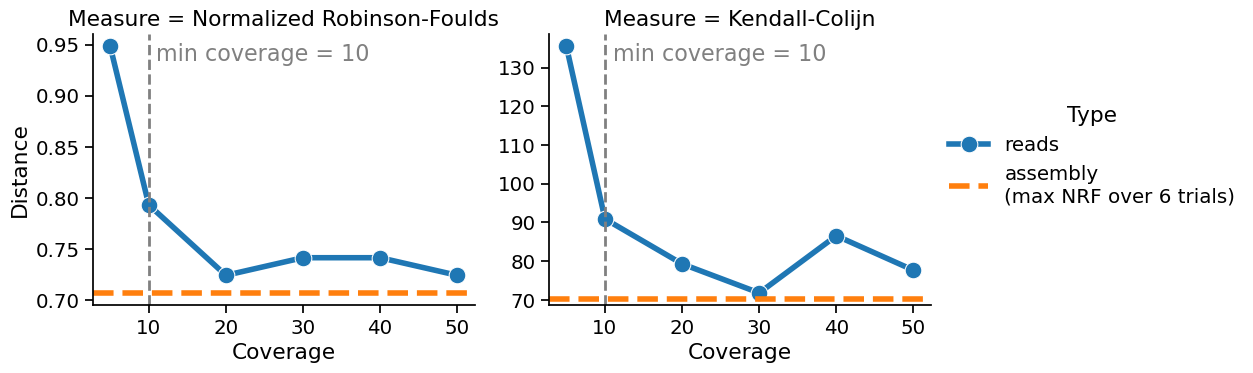

In [38]:
trees_coverage_df = trees_df[(trees_df['Alpha'] == 0.2) & (trees_df['Type'] == 'reads')]

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(
        data=trees_coverage_df, kind="line", col="Measure",
        x="Coverage", y="Distance", hue="Type", style="Type",
        markers=['o'], linewidth=4, markersize=12,
        alpha=1.0, height=4, aspect=1.6,
        facet_kws={'sharey': False, 'sharex': True},
        legend=False,
    )
    
    for ax in g.axes.flat:
        if ax.title.get_text() == "Measure = Normalized Robinson-Foulds":
            ax.axhline(assemblies_rf_distance, color='#ff7f0e', ls='--', lw=4)
        elif ax.title.get_text() == "Measure = Kendall-Colijn":
            ax.axhline(assemblies_kc_distance, color='#ff7f0e', ls='--', lw=4)
        
        ax.axvline(min_cov, color='gray', ls='--', lw=2)
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.1
        ax.text(min_cov + 1, ypos, f'min coverage = {min_cov}', fontdict={'size': 16, 'color': 'gray'})
        
    plt.legend(bbox_to_anchor=(1, 0.8), frameon=False,
               title='Type', loc='upper left',
               labels=['reads', f'assembly\n(max NRF over {number_trials_assemblies} trials)'])
    plt.tight_layout()
    plt.savefig('figures/tree-coverages.pdf')

## 6.3. Reads vs assembly (alpha)

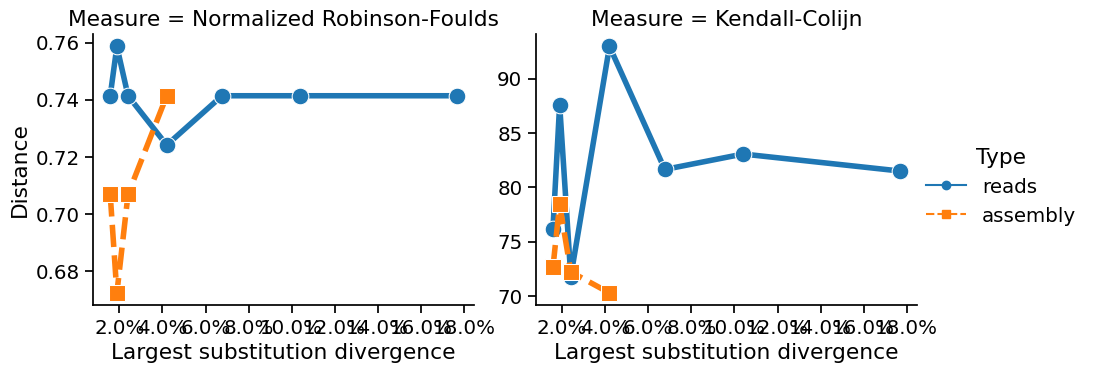

In [39]:
trees_alpha_df = trees_df[trees_df['Coverage'] == 30]
trees_alpha_df

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(
        data=trees_alpha_df, kind="line", col="Measure",
        x="Largest substitution divergence", y="Distance", hue="Type", style="Type",
        markers=markers_data_type, linewidth=4, markersize=12,
        alpha=1.0, height=4, aspect=1.2,
        facet_kws={'sharey': False, 'sharex': True}
    )
    
    for idx, ax in enumerate(g.axes.flat):
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    
    plt.savefig('figures/tree-alpha.pdf')